# Muti-Fidelity ML Models for Halide Peorvskite based Photocatalysts Screening
In this project we have showcased the success of surrogate Machine Learning (ML) models trained on high-throughput density functional theory (HT-DFT) data, to identify Halide Perovskites (HaPs) for efficient photocatalytic water splitting. We trained our ML model on a multi-fidelity HT-DFT dataset of total 985 points (614 PBE + 371 HSE) comprising the target properties of Decomposition Energy and Band Gap. We implemented the state-of-the-art Regularized Greey Forest (RGF) (https://github.com/RGF-team/rgf) regression to generate the predictive models for Decomposition Energy and Band gap. Next, we enumerated a dataset of 151,140 hypothetical perovskites in different phases and used the surrogate models to screen and identify through the huge combinatorial alloyed HaP space. All the python scripts used to perform the ensemble of 4000 RGF models and to calculate the theoretical Solar-to-Hydrogen (STH) efficiency, have been provided at "https://github.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts"

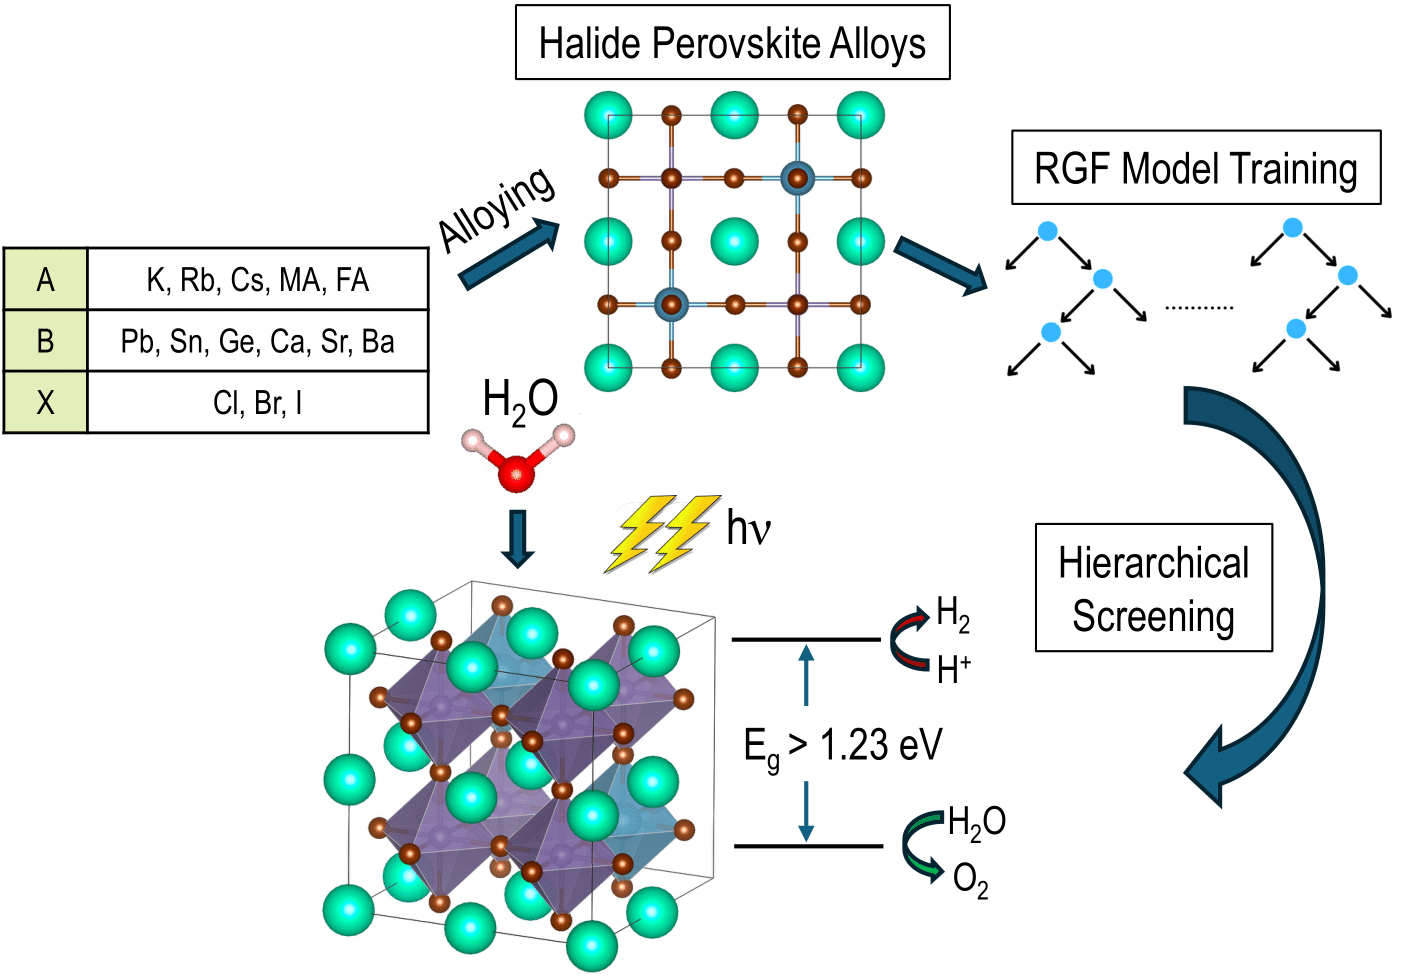

In [ ]:
!which python
!python --version

import warnings
warnings.filterwarnings("ignore")

/usr/local/bin/python
Python 3.10.12


In [ ]:
pip install rgf_python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.8/757.8 kB 12.4 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import csv
import copy
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from pandas import read_csv
import sklearn
from sklearn.decomposition import PCA
from sklearn import linear_model
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, ExpSineSquared
from sklearn.metrics import mean_squared_error as mse
from rgf.sklearn import RGFRegressor
import seaborn as sns
from scipy.integrate import simps
import joblib

## Fetch data
Fetching the training dataset and the 151,140 enumerated dataset


In [ ]:
!wget -O Training_PBE_and_HSE_data.csv https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Training_PBE_and_HSE_data.csv
!wget -O Tol_screened_ensemble_final.csv https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Tol_screened_ensemble_final.csv
!wget -O 3043_screened_comps.csv https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/3043_screened_comps.csv
!wget -O Data_AM1_5G.csv https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Data_AM1_5G.csv
!wget -O Elemental_properties.xlsx https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Elemental_properties.xlsx

df_training = pd.read_csv("./Training_PBE_and_HSE_data.csv")
df_screened_ensemble = pd.read_csv("./Tol_screened_ensemble_final.csv")
df_3043 = pd.read_csv("./3043_screened_comps.csv")
ref_data = pd.read_csv("./Data_AM1_5G.csv")
elem_props = pd.read_excel('Elemental_properties.xlsx')
elements_dict = elem_props.set_index('M').T.to_dict('dict')

--2024-11-15 20:17:13--  https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Training_PBE_and_HSE_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3577052 (3.4M) [text/plain]
Saving to: ‘Training_PBE_and_HSE_data.csv’

Training_PBE_and_HS 100%[===================>]   3.41M  --.-KB/s    in 0.05s   

2024-11-15 20:17:14 (66.2 MB/s) - ‘Training_PBE_and_HSE_data.csv’ saved [3577052/3577052]

--2024-11-15 20:17:14--  https://raw.githubusercontent.com/maitreyo18/Multi-fidelity-screening-of-perovskite-photocatalysts/main/Tol_screened_ensemble_final.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubuserconten

# Visualizing training data

In [ ]:
df_training

,Name,Decomposition Energy,Crystal Structure,Structure,Functional,Band Gap,K,Rb,Cs,MA,...,X_at_wt,X_EA,X_IE,X_hof,X_hov,X_En,X_at_num,X_period,Decomp_mf1_ensemble,Bandgap_mf1_ensemble
0,MA1Ca0.12Sn0.75Pb0.12I3,-0.102625,Cubic,Full Formula (Ca1 Sn6 H48 Pb1 C8 I24 N8)\nRedu...,PBE,1.0389,0.000,0.000,0.000,1.000,...,126.904500,295.300,1008.4,7.7600,20.900000,2.660,53.00,5.000,-0.095089,1.081733
1,Rb0.38Cs0.12MA0.5Pb1I3,0.100325,Cubic,Full Formula (Cs1 Rb3 H24 Pb8 C4 I24 N4)\nRedu...,PBE,1.9355,0.000,0.375,0.125,0.500,...,126.904500,295.300,1008.4,7.7600,20.900000,2.660,53.00,5.000,0.068675,1.834113
2,MA1Ca0.25Ba0.38Sn0.25Pb0.12Br3,0.001848,Cubic,Full Formula (Ba3 Ca2 Sn2 H48 Pb1 C8 Br24 N8)\...,PBE,2.9821,0.000,0.000,0.000,1.000,...,79.904000,324.600,1139.9,5.2860,14.725000,2.960,35.00,4.000,0.001222,3.020886
3,K1Ca0.75Ba0.25Cl3,0.345121,Cubic,Full Formula (K8 Ba2 Ca6 Cl24)\nReduced Formul...,PBE,4.4857,1.000,0.000,0.000,0.000,...,35.452700,348.800,1251.1,3.2100,10.200000,3.160,17.00,3.000,0.339586,4.541026
4,K0.38Rb0.12Cs0.12FA0.38Ca1I3,0.170902,Cubic,Full Formula (Cs1 K3 Rb1 Ca8 H15 C3 I24 N6)\nR...,PBE,3.4386,0.375,0.125,0.125,0.000,...,126.904500,295.300,1008.4,7.7600,20.900000,2.660,53.00,5.000,0.166299,3.535012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
978,MA0.625FA0.375CaBr3,0.020654,Cubic,Full Formula (Ca8 H45 C8 Br24 N11)\nReduced Fo...,HSE,5.2941,0.000,0.000,0.000,0.625,...,79.904000,324.600,1139.9,5.2860,14.725000,2.960,35.00,4.000,-0.007918,5.292739
979,K0.25Rb0.25MA0.5CaCl3,-0.090584,Cubic,Full Formula (K2 Rb2 Ca8 H24 C4 N4 Cl24)\nRedu...,HSE,6.4145,0.250,0.250,0.000,0.500,...,35.452700,348.800,1251.1,3.2100,10.200000,3.160,17.00,3.000,-0.082839,6.374610
980,MACaBr3,-0.087511,Cubic,Full Formula (Ca8 H48 C8 Br24 N8)\nReduced For...,HSE,5.4861,0.000,0.000,0.000,1.000,...,79.904000,324.600,1139.9,5.2860,14.725000,2.960,35.00,4.000,-0.099315,5.481263
981,K0.125Rb0.5Cs0.375CaCl3,-0.182308,Cubic,Full Formula (Cs3 K1 Rb4 Ca8 Cl24)\nReduced Fo...,HSE,6.3120,0.125,0.500,0.375,0.000,...,35.452700,348.800,1251.1,3.2100,10.200000,3.160,17.00,3.000,-0.172813,6.216199


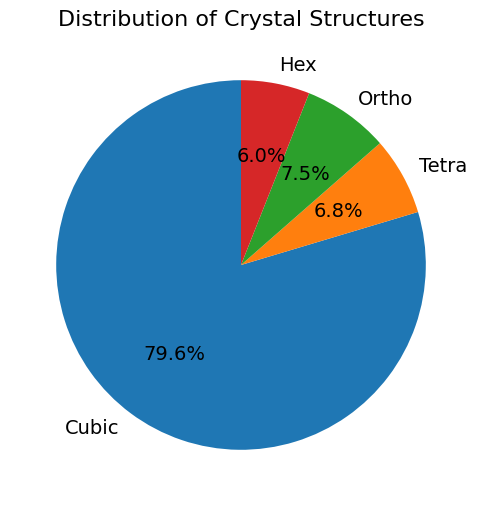

In [ ]:
# Visualize the training data across phases
plt.figure(figsize=(9, 6))
crystal_counts = df_training[["Cubic", "Tetra", "Ortho", "Hex"]].sum()

crystal_counts.plot.pie(autopct='%1.1f%%', startangle=90, fontsize=14,
                        textprops={'fontsize': 14})

plt.title("Distribution of Crystal Structures", fontsize=16)
plt.ylabel("")
plt.show()

# Pearson correlation coefficient for the training data vs target properties (Decomposition Energy (ΔH$_{decomp}$ , eV) and Band Gap (E$_g$ , eV))

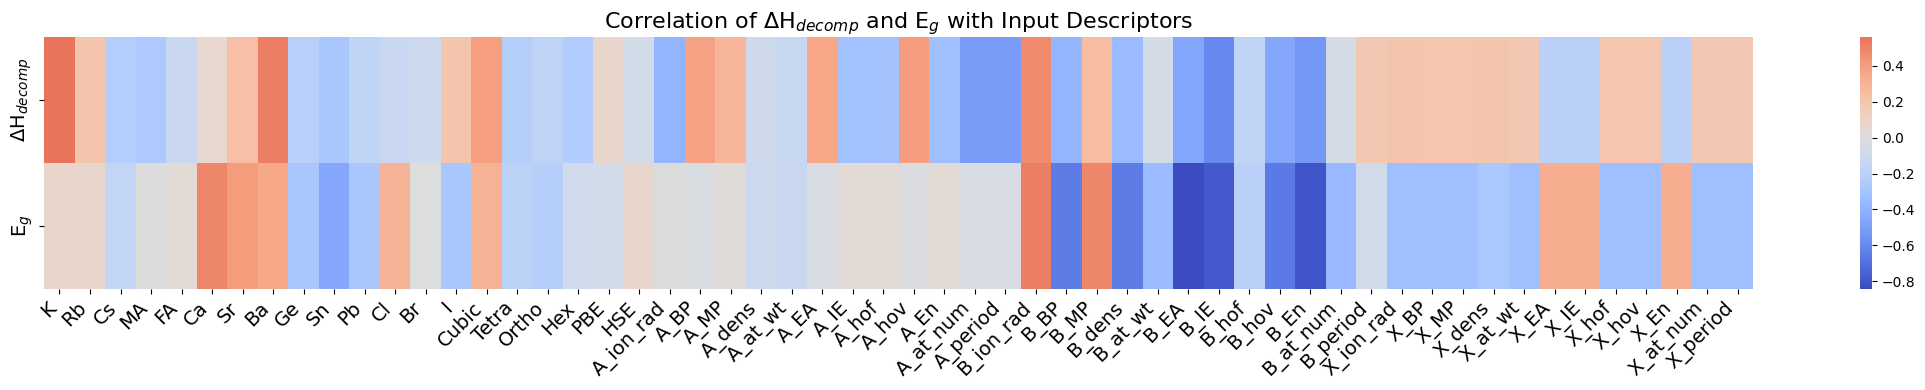

In [ ]:
selected_features = [
    "K", "Rb", "Cs", "MA", "FA", "Ca", "Sr", "Ba", "Ge", "Sn", "Pb", "Cl", "Br", "I", "Cubic",
    "Tetra", "Ortho", "Hex", "PBE", "HSE", "A_ion_rad", "A_BP", "A_MP", "A_dens", "A_at_wt",
    "A_EA", "A_IE", "A_hof", "A_hov", "A_En", "A_at_num", "A_period", "B_ion_rad", "B_BP",
    "B_MP", "B_dens", "B_at_wt", "B_EA", "B_IE", "B_hof", "B_hov", "B_En", "B_at_num",
    "B_period", "X_ion_rad", "X_BP", "X_MP", "X_dens", "X_at_wt", "X_EA", "X_IE", "X_hof",
    "X_hov", "X_En", "X_at_num", "X_period"
]
target_columns = ["Decomposition Energy", "Band Gap"]

# Calculate the correlation matrix
corr_with_targets = df_training[selected_features + target_columns].corr()[target_columns].loc[selected_features]

# Rename the target columns for the plot
corr_with_targets = corr_with_targets.rename(columns={
    "Decomposition Energy": "ΔH$_{decomp}$",
    "Band Gap": "E$_g$"
})

# Set up the plot
plt.figure(figsize=(22, 4))
sns.heatmap(corr_with_targets.T, annot=False, cmap="coolwarm", center=0)

# Plot adjustments
plt.title("Correlation of ΔH$_{decomp}$ and E$_g$ with Input Descriptors", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#Separating functionals
df_PBE = df_training[(df_training["PBE"] == 1) & (df_training["HSE"] == 0)]
df_HSE = df_training[(df_training["PBE"] == 0) & (df_training["HSE"] == 1)]

In [ ]:
def mixing_identifier(df):
    A_site = ['K', 'Rb', 'Cs', 'MA', 'FA']
    B_site = ['Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb']
    X_site = ['Cl', 'Br', 'I']

    df_inorganic = df[(df['MA'] == 0) & (df['FA'] == 0)]
    df_hybrid = df[(df['MA'] != 0) | (df['FA'] != 0)]
    #print("Hybrid", df_hybrid)

    inorganic_pure = []
    inorganic_A_mix = []
    inorganic_B_mix = []
    inorganic_X_mix = []
    inorganic_A_B_mix = []
    inorganic_A_X_mix = []
    inorganic_B_X_mix = []




    for i in range(len(df_inorganic)):
        row = df_inorganic.iloc[i]
        values_A = [row[col] for col in A_site]
        values_B = [row[col] for col in B_site]
        values_X = [row[col] for col in X_site]

        nonzero_counts_A = sum(1 for value in values_A if value > 0)
        nonzero_counts_B = sum(1 for value in values_B if value > 0)
        nonzero_counts_X = sum(1 for value in values_X if value > 0)

        if nonzero_counts_A == 1 and nonzero_counts_B == 1 and nonzero_counts_X == 1 :
            inorganic_pure.append(row)

        if nonzero_counts_A > 1 and nonzero_counts_B == 1 and nonzero_counts_X == 1 :
            inorganic_A_mix.append(row)

        if nonzero_counts_A == 1 and nonzero_counts_B > 1 and nonzero_counts_X == 1 :
            inorganic_B_mix.append(row)

        if nonzero_counts_A == 1 and nonzero_counts_B == 1 and nonzero_counts_X > 1 :
            inorganic_X_mix.append(row)

        if nonzero_counts_A > 1 and nonzero_counts_B > 1 and nonzero_counts_X == 1 :
            inorganic_A_B_mix.append(row)

        if nonzero_counts_A > 1 and nonzero_counts_B == 1 and nonzero_counts_X > 1 :
            inorganic_A_X_mix.append(row)

        if nonzero_counts_A == 1 and nonzero_counts_B > 1 and nonzero_counts_X > 1 :
            inorganic_B_X_mix.append(row)

    df_inorganic_pure = pd.DataFrame(inorganic_pure).reset_index(drop=True)
    df_inorganic_A_mix = pd.DataFrame(inorganic_A_mix).reset_index(drop=True)
    df_inorganic_B_mix = pd.DataFrame(inorganic_B_mix).reset_index(drop=True)
    df_inorganic_X_mix = pd.DataFrame(inorganic_X_mix).reset_index(drop=True)
    df_inorganic_A_B_mix = pd.DataFrame(inorganic_A_B_mix).reset_index(drop=True)
    df_inorganic_A_X_mix = pd.DataFrame(inorganic_A_X_mix).reset_index(drop=True)
    df_inorganic_B_X_mix = pd.DataFrame(inorganic_B_X_mix).reset_index(drop=True)

    hybrid_pure = []
    hybrid_A_mix = []
    hybrid_B_mix = []
    hybrid_X_mix = []
    hybrid_A_B_mix = []
    hybrid_A_X_mix = []
    hybrid_B_X_mix = []


    for j in range(len(df_hybrid)):
        row_org = df_hybrid.iloc[j]
        values_A_org = [row_org[col] for col in A_site]
        values_B_org = [row_org[col] for col in B_site]
        values_X_org = [row_org[col] for col in X_site]

        nonzero_counts_A_org = sum(1 for value in values_A_org if value > 0)
        nonzero_counts_B_org = sum(1 for value in values_B_org if value > 0)
        nonzero_counts_X_org = sum(1 for value in values_X_org if value > 0)

        if nonzero_counts_A_org == 1 and nonzero_counts_B_org == 1 and nonzero_counts_X_org == 1 :
            hybrid_pure.append(row_org)

        if nonzero_counts_A_org > 1 and nonzero_counts_B_org == 1 and nonzero_counts_X_org == 1 :
            hybrid_A_mix.append(row_org)

        if nonzero_counts_A_org == 1 and nonzero_counts_B_org > 1 and nonzero_counts_X_org == 1 :
            hybrid_B_mix.append(row_org)

        if nonzero_counts_A_org == 1 and nonzero_counts_B_org == 1 and nonzero_counts_X_org > 1 :
            hybrid_X_mix.append(row_org)

        if nonzero_counts_A_org > 1 and nonzero_counts_B_org > 1 and nonzero_counts_X_org == 1 :
            hybrid_A_B_mix.append(row_org)

        if nonzero_counts_A_org > 1 and nonzero_counts_B_org == 1 and nonzero_counts_X_org > 1 :
            hybrid_A_X_mix.append(row_org)

        if nonzero_counts_A_org == 1 and nonzero_counts_B_org > 1 and nonzero_counts_X_org > 1 :
            hybrid_B_X_mix.append(row_org)

    df_hybrid_pure = pd.DataFrame(hybrid_pure).reset_index(drop=True)
    df_hybrid_A_mix = pd.DataFrame(hybrid_A_mix).reset_index(drop=True)
    df_hybrid_B_mix = pd.DataFrame(hybrid_B_mix).reset_index(drop=True)
    df_hybrid_X_mix = pd.DataFrame(hybrid_X_mix).reset_index(drop=True)
    df_hybrid_A_B_mix = pd.DataFrame(hybrid_A_B_mix).reset_index(drop=True)
    df_hybrid_A_X_mix = pd.DataFrame(hybrid_A_X_mix).reset_index(drop=True)
    df_hybrid_B_X_mix = pd.DataFrame(hybrid_B_X_mix).reset_index(drop=True)

    return df_inorganic_pure, df_inorganic_A_mix, df_inorganic_B_mix, df_inorganic_X_mix, df_inorganic_A_B_mix, df_inorganic_A_X_mix, df_inorganic_B_X_mix, df_hybrid_pure, df_hybrid_A_mix, df_hybrid_B_mix, df_hybrid_X_mix, df_hybrid_A_B_mix, df_hybrid_A_X_mix, df_hybrid_B_X_mix


In [ ]:
df_inorganic_pure_pbe, df_inorganic_A_mix_pbe, df_inorganic_B_mix_pbe, df_inorganic_X_mix_pbe, df_inorganic_A_B_mix_pbe, df_inorganic_A_X_mix_pbe, df_inorganic_B_X_mix_pbe, df_hybrid_pure_pbe, df_hybrid_A_mix_pbe, df_hybrid_B_mix_pbe, df_hybrid_X_mix_pbe, df_hybrid_A_B_mix_pbe, df_hybrid_A_X_mix_pbe, df_hybrid_B_X_mix_pbe = mixing_identifier(df_PBE)
df_inorganic_pure_hse, df_inorganic_A_mix_hse, df_inorganic_B_mix_hse, df_inorganic_X_mix_hse, df_inorganic_A_B_mix_hse, df_inorganic_A_X_mix_hse, df_inorganic_B_X_mix_hse, df_hybrid_pure_hse, df_hybrid_A_mix_hse, df_hybrid_B_mix_hse, df_hybrid_X_mix_hse, df_hybrid_A_B_mix_hse, df_hybrid_A_X_mix_hse, df_hybrid_B_X_mix_hse = mixing_identifier(df_HSE)

# Visualize decomposition energy vs band gap distribution across functionals

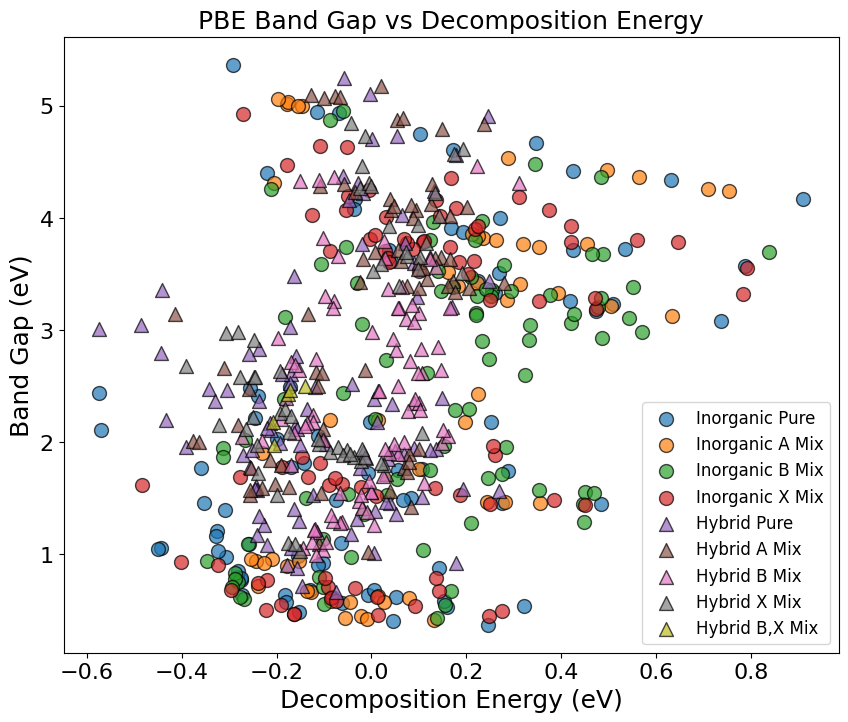

In [ ]:
functional = "PBE" # Use "HSE" for visualizing HSE data

pbe_dfs = [
    df_inorganic_pure_pbe, df_inorganic_A_mix_pbe, df_inorganic_B_mix_pbe,
    df_inorganic_X_mix_pbe, df_inorganic_A_B_mix_pbe, df_inorganic_A_X_mix_pbe,
    df_inorganic_B_X_mix_pbe, df_hybrid_pure_pbe, df_hybrid_A_mix_pbe,
    df_hybrid_B_mix_pbe, df_hybrid_X_mix_pbe, df_hybrid_A_B_mix_pbe,
    df_hybrid_A_X_mix_pbe, df_hybrid_B_X_mix_pbe
]

hse_dfs = [
    df_inorganic_pure_hse, df_inorganic_A_mix_hse, df_inorganic_B_mix_hse,
    df_inorganic_X_mix_hse, df_inorganic_A_B_mix_hse, df_inorganic_A_X_mix_hse,
    df_inorganic_B_X_mix_hse, df_hybrid_pure_hse, df_hybrid_A_mix_hse,
    df_hybrid_B_mix_hse, df_hybrid_X_mix_hse, df_hybrid_A_B_mix_hse,
    df_hybrid_A_X_mix_hse, df_hybrid_B_X_mix_hse
]

labels = [
    "Inorganic Pure", "Inorganic A Mix", "Inorganic B Mix", "Inorganic X Mix",
    "Inorganic A,B Mix", "Inorganic A,X Mix", "Inorganic B,X Mix",
    "Hybrid Pure", "Hybrid A Mix", "Hybrid B Mix", "Hybrid X Mix",
    "Hybrid A,B Mix", "Hybrid A,X Mix", "Hybrid B,X Mix"
]

dfs = pbe_dfs if functional == "PBE" else hse_dfs

# Plot Band Gap vs Decomposition Energy
plt.figure(figsize=(10, 8))

for df, label in zip(dfs, labels):
    if not df.empty:
        marker_style = 'o' if 'Inorganic' in label else '^'
        plt.scatter(
            df["Decomposition Energy"], df["Band Gap"],
            label=label, marker=marker_style, edgecolor='black', s=100, alpha=0.7
        )

plt.xlabel("Decomposition Energy (eV)", fontsize=18)
plt.ylabel("Band Gap (eV)", fontsize=18)
plt.title(f"{functional} Band Gap vs Decomposition Energy", fontsize=18)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=12)
plt.show()

# Visualizing the ML predictions on enumerated 67,916 compositions post tolerance factor screening from 151,140 initial data points

In [ ]:
df_screened_ensemble

,Unnamed: 0.1,Unnamed: 0,Index,Formula,K,Rb,Cs,MA,FA,Ca,...,Cubic,Tetra,Ortho,Hex,PBE,HSE,Expt,Decomp(PBE),Decomp(HSE),Band gap(HSE-mf1)
0,0,0,0,RbGe0.625Sn0.250Sr0.125Cl3,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,1,0,-0.136648,0.047374,2.112412
1,1,1,1,RbGe0.625Sn0.375Cl3,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,1,0,-0.207158,-0.042562,1.606548
2,2,2,2,RbGe0.625Pb0.125Sn0.125Sr0.125Cl3,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,1,0,-0.143533,0.031932,1.920846
3,3,3,3,RbGe0.625Pb0.125Sn0.250Cl3,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,1,0,-0.183948,-0.025908,1.564668
4,4,4,4,RbGe0.625Pb0.250Sn0.125Cl3,0.0,1.0,0.0,0.0,0.0,0.00,...,1,0,0,0,0,1,0,-0.168341,-0.010930,1.560484
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67911,67911,67911,67911,CsBa0.375Ca0.125Ge0.375Sn0.125Cl3,0.0,0.0,1.0,0.0,0.0,0.13,...,0,0,0,1,0,1,0,-0.094719,0.002251,3.967263
67912,67912,67912,67912,CsBa0.375Ca0.125Ge0.375Pb0.125Cl3,0.0,0.0,1.0,0.0,0.0,0.13,...,0,0,0,1,0,1,0,-0.082060,0.000605,4.127859
67913,67913,67913,67913,CsBa0.375Ca0.125Ge0.500Cl3,0.0,0.0,1.0,0.0,0.0,0.13,...,0,0,0,1,0,1,0,-0.120669,-0.010707,4.301520
67914,67914,67914,67914,CsBa0.375Ca0.250Ge0.375Cl3,0.0,0.0,1.0,0.0,0.0,0.25,...,0,0,0,1,0,1,0,-0.097974,-0.003121,4.594275


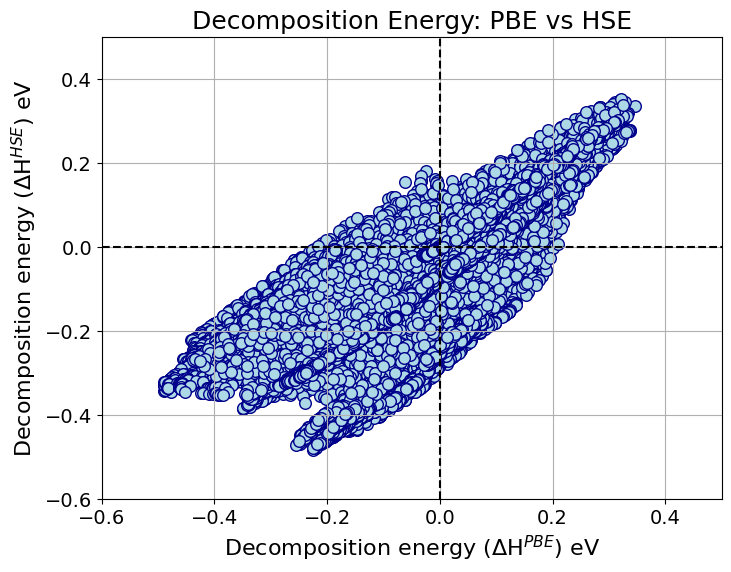

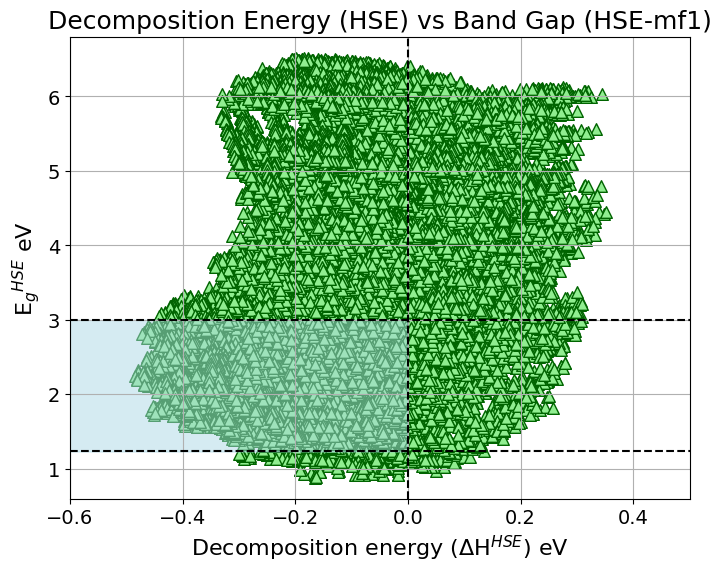

In [ ]:
# Plot 1: Decomp(PBE) vs Decomp(HSE)
plt.figure(figsize=(8, 6))
plt.scatter(df_screened_ensemble["Decomp(PBE)"], df_screened_ensemble["Decomp(HSE)"],
            marker='o', color='lightblue', edgecolor='darkblue', s=70)
plt.xlabel("Decomposition energy ($\Delta$H$^{PBE}$) eV", fontsize=16)
plt.ylabel("Decomposition energy ($\Delta$H$^{HSE}$) eV", fontsize=16)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1.5)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1.5)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim([-0.6, 0.5])
plt.ylim([-0.6, 0.5])
plt.title("Decomposition Energy: PBE vs HSE", fontsize=18)
plt.grid(True)
plt.show()

# Plot 2: Decomp(HSE) vs Band gap(HSE-mf1)
plt.figure(figsize=(8, 6))
plt.scatter(df_screened_ensemble['Decomp(HSE)'], df_screened_ensemble['Band gap(HSE-mf1)'],
            marker='^', color='lightgreen', edgecolor='darkgreen', s=70)
plt.xlabel('Decomposition energy ($\Delta$H$^{HSE}$) eV', fontsize=16)
plt.ylabel('E$_g$$^{HSE}$ eV', fontsize=16)
plt.axvline(x=0, color='k', linestyle='--', linewidth=1.5)

plt.hlines(y=1.23, xmin=-0.6, xmax=0.5, color='k', linestyle='--', linewidth=1.5)
plt.hlines(y=3, xmin=-0.6, xmax=0.5, color='k', linestyle='--', linewidth=1.5)
plt.xlim([-0.6, 0.5])

x = np.linspace(-0.6, 0.5, 1000)
y1 = np.full_like(x, 1.23)
y2 = np.full_like(x, 3)
plt.fill_between(x, y1, y2, where=(x < 0), color='lightblue', alpha=0.5)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Decomposition Energy (HSE) vs Band Gap (HSE-mf1)", fontsize=18)
plt.grid(True)
plt.savefig('gap_vs_decomp.png', dpi=600)
plt.show()

# Hierarchical Screening of enumerated compositions
After enumerating the 151,140 HaP compositions, we performed this hierarchical screening approach to screen and identify the compositions that are thermodynamically stable and showed suitable band gaps and band alignments. This screening leads a reduced dataset of 3043 suitable compositions.

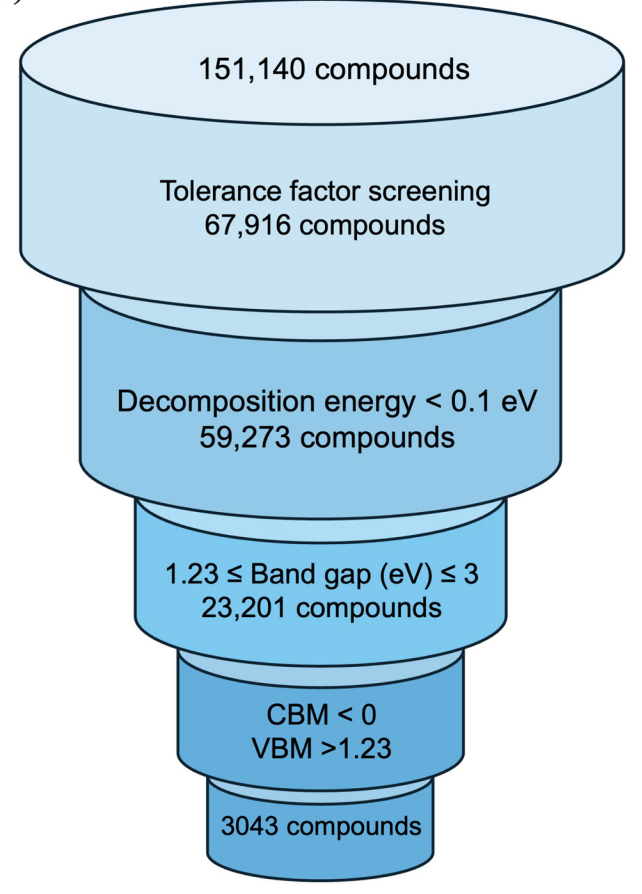

# Visualize the STH efficiency of purely inorganic vs hybrid HaPs

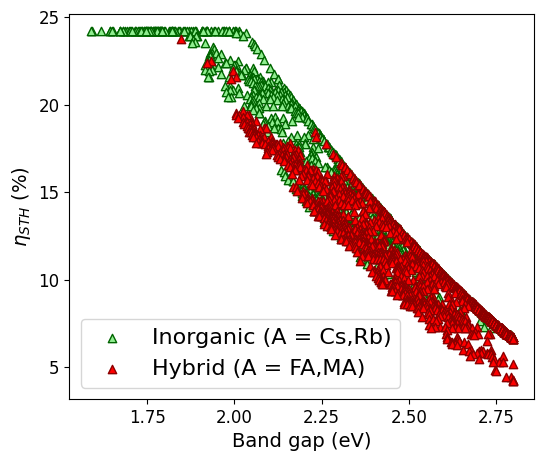

In [ ]:
rows_org = []
rows_inorg = []

for i in range(0, len(df_3043.index)):
    if (df_3043.loc[i, 'Cs'] == 1 or df_3043.loc[i, 'Rb'] == 1) and (df_3043.loc[i, 'MA'] == 0 and df_3043.loc[i, 'FA'] == 0):
        rows_inorg.append(i)
    else:
        rows_org.append(i)

inorg = df_3043.iloc[rows_inorg]
org = df_3043.iloc[rows_org]

plt.figure(figsize=(6, 5))
plt.rc('font', family='sans-serif', size=16)
plt.scatter(inorg['Band gap(HSE-mf1)'], inorg['n_STH(%)'], marker='^', color='lightgreen', edgecolor='darkgreen', label='Inorganic (A = Cs,Rb)')
plt.scatter(org['Band gap(HSE-mf1)'], org['n_STH(%)'], marker='^', color='red', edgecolor='darkred', label='Hybrid (A = FA,MA)')

plt.xlabel('Band gap (eV)', fontsize=14)
plt.ylabel('$\eta$$_{STH}$ (%)', fontsize=14)
plt.legend()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.savefig('Organic-Inorganic.png', dpi=600)
plt.show()


# Scatter plot to visualize the dependance of STH efficiency w.r.t to band gap and electronegativity

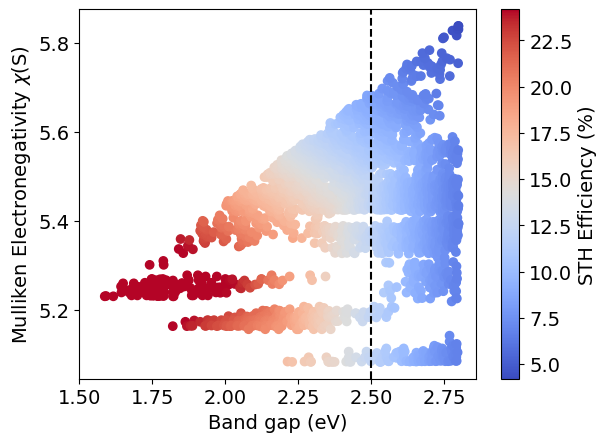

In [ ]:
scatter = plt.scatter(df_3043['Band gap(HSE-mf1)'], df_3043['x(S)'], c=df_3043['n_STH(%)'], cmap='coolwarm')

cbar = plt.colorbar(scatter, label='STH Efficiency (%)')
cbar.set_label('STH Efficiency (%)', size=14)
cbar.ax.tick_params(labelsize=14)

plt.xlabel('Band gap (eV)', fontsize=14)
plt.ylabel('Mulliken Electronegativity $\chi$(S)', fontsize=14)

plt.axvline(x=2.5, color='k', linestyle='--')

plt.xticks(np.arange(1.5, 3, 0.25), fontsize=14)
plt.yticks(fontsize=14)

plt.show()


# Predicting the band alignment and STH efficiency of new compositions by quesrying the screened compositions or ML predictions


Provide the input compositions, phase and functional for querying

In [ ]:
# Input composition as a list
#A_site = ['K', 'Rb', 'Cs', 'MA', 'FA',]
#B_site = ['Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb']
#X_site = ['Cl', 'Br', 'I']

compositions = ["Cs0.5K0.5PbBr1.5Cl1.5", "CsCa0.25Ge0.75Br3", "FAPbI3"] # Input composition string like this
phase = ["tetra", "cubic", "cubic"] # phases options: "cubic"/"tetra"/"ortho"/"hex"
prediction_fidelity = ["HSE"] # or "PBE"

In [ ]:
def parse_compositions(compositions, phase, prediction_fidelity):
    """Parse compositions and create dataframe with element fractions and properties"""

    # Input composition as a list
    A_site = ['K', 'Rb', 'Cs', 'MA', 'FA']
    B_site = ['Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb']
    X_site = ['Cl', 'Br', 'I']

    elements = ["K", "Rb", "Cs", "MA", "FA", "Ca", "Sr", "Ba", "Ge", "Sn", "Pb", "Cl", "Br", "I"]
    prediction_fidelity = prediction_fidelity * len(compositions)

    # Initialize an empty list to store data
    data = []
    pattern = r"(MA|FA|[A-Z][a-z]*)([0-9\.]*)"

    for comp in compositions:
        comp_dict = {element: 0 for element in elements}
        comp_dict['Composition'] = comp

        matches = re.findall(pattern, comp)

        for element, fraction in matches:
            if element in comp_dict:
                fraction_value = float(fraction) if fraction else 1.0
                if element in ["Cl", "Br", "I"]:
                    fraction_value /= 3

                comp_dict[element] = fraction_value
        data.append(comp_dict)

    df = pd.DataFrame(data)
    df = df[['Composition'] + elements]

    # Define the property columns
    property_columns = ['Ion_rad', 'BP', 'MP', 'Density', 'At_wt', 'Elec_Aff',
                       'Ion_Energy', 'Heat_fusion', 'Heat_vap', 'Electronegativity',
                       'At_num', 'Period']

    # Initialize the columns in df
    for site in ['A', 'B', 'X']:
        for prop in property_columns:
            df[f'{site}_{prop}'] = 0.0

    # Calculate the weighted averages
    for idx, row in df.iterrows():
        for site, site_elements in zip(['A', 'B', 'X'], [A_site, B_site, X_site]):
            for prop in property_columns:
                weighted_sum = 0.0
                total_fraction = 0.0
                for element in site_elements:
                    fraction = row.get(element, 0)
                    weighted_sum += fraction * elements_dict[element].get(prop, 0)
                    total_fraction += fraction
                if total_fraction > 0:
                    df.at[idx, f'{site}_{prop}'] = weighted_sum / total_fraction

    df["Cubic"] = 0
    df["Tetra"] = 0
    df["Ortho"] = 0
    df["Hex"] = 0
    df["PBE"] = 0
    df["HSE"] = 0

    phase_mapping = {
        "cubic": "Cubic",
        "tetra": "Tetra",
        "ortho": "Ortho",
        "hex": "Hex"
    }

    for i, (ph, fidelity) in enumerate(zip(phase, prediction_fidelity)):
        df.at[i, phase_mapping[ph.lower()]] = 1
        df.at[i, fidelity] = 1

    return df

df = parse_compositions(compositions, phase, prediction_fidelity)
df

,Composition,K,Rb,Cs,MA,FA,Ca,Sr,Ba,Ge,...,X_Heat_vap,X_Electronegativity,X_At_num,X_Period,Cubic,Tetra,Ortho,Hex,PBE,HSE
0,Cs0.5K0.5PbBr1.5Cl1.5,0.5,0,0.5,0,0.0,0.00,0,0,0.00,...,12.4625,3.06,26.0,3.5,0,1,0,0,0,1
1,CsCa0.25Ge0.75Br3,0.0,0,1.0,0,0.0,0.25,0,0,0.75,...,14.7250,2.96,35.0,4.0,1,0,0,0,0,1
2,FAPbI3,0.0,0,0.0,0,1.0,0.00,0,0,0.00,...,20.9000,2.66,53.0,5.0,1,0,0,0,0,1


In [ ]:
h = 6.62607004081E-34
c = 299792458

ref_data['Energy(eV)'] = None
ref_data['P(hw)'] = None
ref_data['P(hw)/hw'] = None

for i in range(0, len(ref_data.index)):
  ref_data.loc[i, 'Energy(eV)'] = 1239.84193/ref_data.loc[i, 'Wavelength']
  ref_data.loc[i, 'P(hw)'] = ((ref_data.loc[i, 'Global'] * ref_data.loc[i, 'Wavelength'])/(h*c)) * (10**(-15))
  ref_data.loc[i, 'P(hw)/hw'] = ref_data.loc[i, 'P(hw)']/ref_data.loc[i, 'Energy(eV)']

ref_data = ref_data[::-1]
ref_data = ref_data.reset_index(drop=True)


# Define the consistent column order for training data
df_training_columns = [
    'K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge', 'Sn', 'Pb', 'Cl', 'Br', 'I',
    'Cubic', 'Tetra', 'Ortho', 'Hex', 'PBE', 'HSE', 'A_ion_rad', 'A_BP', 'A_MP', 'A_dens',
    'A_at_wt', 'A_EA', 'A_IE', 'A_hof', 'A_hov', 'A_En', 'A_at_num', 'A_period', 'B_ion_rad',
    'B_BP', 'B_MP', 'B_dens', 'B_at_wt', 'B_EA', 'B_IE', 'B_hof', 'B_hov', 'B_En', 'B_at_num',
    'B_period', 'X_ion_rad', 'X_BP', 'X_MP', 'X_dens', 'X_at_wt', 'X_EA', 'X_IE', 'X_hof',
    'X_hov', 'X_En', 'X_at_num', 'X_period'
]

# Column mapping for different naming conventions
df_column_mapping = {
    'A_Ion_rad': 'A_ion_rad',
    'A_Density': 'A_dens',
    'A_At_wt': 'A_at_wt',
    'A_Elec_Aff': 'A_EA',
    'A_Ion_Energy': 'A_IE',
    'A_Heat_fusion': 'A_hof',
    'A_Heat_vap': 'A_hov',
    'A_Electronegativity': 'A_En',
    'A_At_num': 'A_at_num',
    'A_Period': 'A_period',
    'B_Ion_rad': 'B_ion_rad',
    'B_Density': 'B_dens',
    'B_At_wt': 'B_at_wt',
    'B_Elec_Aff': 'B_EA',
    'B_Ion_Energy': 'B_IE',
    'B_Heat_fusion': 'B_hof',
    'B_Heat_vap': 'B_hov',
    'B_Electronegativity': 'B_En',
    'B_At_num': 'B_at_num',
    'B_Period': 'B_period',
    'X_Ion_rad': 'X_ion_rad',
    'X_Density': 'X_dens',
    'X_At_wt': 'X_at_wt',
    'X_Elec_Aff': 'X_EA',
    'X_Ion_Energy': 'X_IE',
    'X_Heat_fusion': 'X_hof',
    'X_Heat_vap': 'X_hov',
    'X_Electronegativity': 'X_En',
    'X_At_num': 'X_at_num',
    'X_Period': 'X_period'
}

def calculate_x_S(row, use_training_format=False):
    """Calculate x(S) using electronegativity values"""
    if use_training_format:
        # For training data format
        A_En_mull = ((row['A_IE'] + row['A_EA']) / 2) * 0.0103643
        B_En_mull = ((row['B_IE'] + row['B_EA']) / 2) * 0.0103643
        X_En_mull = ((row['X_IE'] + row['X_EA']) / 2) * 0.0103643
    else:
        # For input data format
        A_En_mull = ((row['A_Ion_Energy'] + row['A_Elec_Aff']) / 2) * 0.0103643
        B_En_mull = ((row['B_Ion_Energy'] + row['B_Elec_Aff']) / 2) * 0.0103643
        X_En_mull = ((row['X_Ion_Energy'] + row['X_Elec_Aff']) / 2) * 0.0103643

    return (A_En_mull * B_En_mull * (X_En_mull**3))**(1/5)

def calculate_band_positions(x_S, band_gap):
    """Calculate CBM and VBM positions"""
    CBM = x_S - 4.44 - (band_gap / 2)
    VBM = x_S - 4.44 + (band_gap / 2)
    return CBM, VBM

def E_over(Eg, CBM, VBM):
    """Calculate overpotential"""
    HER = np.abs(CBM)
    OER = np.abs(VBM - 1.23)

    if (HER >= 0.2) and (OER >= 0.6):
        return Eg
    elif (HER < 0.2) and (OER >= 0.6):
        return Eg + 0.2 - HER
    elif (HER >= 0.2) and (OER < 0.6):
        return Eg + 0.6 - OER
    else:
        return Eg + 0.8 - HER - OER

def n_abs(ref_data, Eg):
    """Calculate absorption efficiency"""
    solar_data = ref_data[ref_data['Energy(eV)'] >= Eg]
    num = simps(solar_data['P(hw)'], solar_data['Energy(eV)'])
    denm = simps(ref_data['P(hw)'], ref_data['Energy(eV)'])
    return num / denm

def n_cu(ref_data, Eg, CBM, VBM):
    """Calculate charge utilization efficiency"""
    gap = E_over(Eg, CBM, VBM)
    solar_data = ref_data[ref_data['Energy(eV)'] >= Eg]
    E_data = ref_data[ref_data['Energy(eV)'] >= gap]
    G = 1.23
    num = G * simps(E_data['P(hw)/hw'], E_data['Energy(eV)'])
    denm = simps(solar_data['P(hw)'], solar_data['Energy(eV)'])
    return num / denm

def calculate_sth_efficiency(ref_data, band_gap, CBM, VBM):
    """Calculate STH efficiency if material is suitable for water splitting"""
    if CBM <= 0 and VBM >= 1.23:
        n_abs_val = n_abs(ref_data, band_gap) * 100
        n_cu_val = n_cu(ref_data, band_gap, CBM, VBM) * 100
        n_STH = (n_abs_val * n_cu_val) / 100
        return True, n_STH
    return False, 0

def train_predict_models(X, y_decomp, y_gap):
    """Train RGF models for decomposition energy and band gap"""
    rgf_params = {
        'loss': 'LS',
        'algorithm': 'RGF',
        'l2': 0.1,
        'learning_rate': 0.1,
        'n_iter': 20,
        'sl2': 0.2,
        'memory_policy': 'generous',
        'min_samples_leaf': 25,
        'max_leaf': 1000
    }

    # Train decomposition energy model
    rgf_decomp = RGFRegressor(**rgf_params)
    rgf_decomp.fit(X, y_decomp)

    # Train band gap model
    rgf_gap = RGFRegressor(**rgf_params)
    rgf_gap.fit(X, y_gap)

    return rgf_decomp, rgf_gap


def get_phase(row):
    """Determine the phase based on structure columns"""
    if row.get('Cubic', 0) == 1:
        return 'Cubic'
    elif row.get('Tetra', 0) == 1:
        return 'Tetragonal'
    elif row.get('Ortho', 0) == 1:
        return 'Orthorhombic'
    elif row.get('Hex', 0) == 1:
        return 'Hexagonal'
    return 'Unknown'


def find_matches_in_datasets(row, df_training, df_screened_ensemble):
    """Find matching compositions in training and screened datasets"""
    comparison_columns = [
        'K', 'Rb', 'Cs', 'MA', 'FA', 'Ca', 'Sr', 'Ba', 'Ge',
        'Sn', 'Pb', 'Cl', 'Br', 'I', 'Cubic', 'Tetra',
        'Ortho', 'Hex'
    ]

    # Create boolean masks for matching rows
    training_matches = None
    screened_matches = None

    try:
        # Check training data
        training_mask = np.ones(len(df_training), dtype=bool)
        for col in comparison_columns:
            if col in df_training.columns:
                training_mask &= (df_training[col] == row[col])
        if any(training_mask):
            training_matches = df_training[training_mask]

        # Check screened ensemble data
        screened_mask = np.ones(len(df_screened_ensemble), dtype=bool)
        for col in comparison_columns:
            if col in df_screened_ensemble.columns:
                screened_mask &= (df_screened_ensemble[col] == row[col])
        if any(screened_mask):
            screened_matches = df_screened_ensemble[screened_mask]

    except Exception as e:
        print(f"Error in matching: {str(e)}")

    return training_matches, screened_matches


def find_dft_and_ml_data(df, df_training, df_screened_ensemble, ref_data):
    """Main function to analyze compositions and calculate efficiencies"""
    print("Starting analysis...")

    # Prepare training data
    X_train = df_training[df_training_columns].values
    y_decomp = df_training['Decomposition Energy'].values
    y_gap = df_training['Band Gap'].values

    # Train ML models
    print("Training ML models...")
    rgf_decomp, rgf_gap = train_predict_models(X_train, y_decomp, y_gap)
    print("ML models trained successfully")

    results = []

    for idx, row in df.iterrows():
        print(f"\nProcessing composition {idx + 1}/{len(df)}: {row['Composition']}")

        # Find matches in existing datasets
        training_matches, screened_matches = find_matches_in_datasets(row, df_training, df_screened_ensemble)

        # Calculate x(S)
        try:
            x_S = calculate_x_S(row)
        except Exception as e:
            print(f"Error calculating x(S): {str(e)}")
            continue

        # Get phase
        phase = get_phase(row)

        # Create feature vector for ML prediction if needed
        input_features = np.zeros(len(df_training_columns))
        for i, col in enumerate(df_training_columns):
            orig_col = {v: k for k, v in df_column_mapping.items()}.get(col, col)
            input_features[i] = row.get(orig_col, row.get(col, 0))

        # Handle DFT matches
        if training_matches is not None and len(training_matches) > 0:
            print(f"\nFound {len(training_matches)} DFT match(es) for {row['Composition']}:")

            for _, match in training_matches.iterrows():
                result_dict = {'Composition': row['Composition'], 'x(S)': x_S, 'Phase': phase}
                print(f"\nMatch {match.name}:")
                print(f"Phase: {phase}")
                print(f"Functional: {match.get('Functional', 'N/A')}")
                print(f"Decomposition Energy: {match['Decomposition Energy']:.3f} eV")
                print(f"Band Gap: {match['Band Gap']:.3f} eV")

                band_gap = match['Band Gap']
                CBM, VBM = calculate_band_positions(x_S, band_gap)
                is_suitable, sth_efficiency = calculate_sth_efficiency(ref_data, band_gap, CBM, VBM)

                result_dict.update({
                    'Source': 'DFT',
                    'Functional': match.get('Functional', 'N/A'),
                    'Band_Gap': band_gap,
                    'CBM': CBM,
                    'VBM': VBM,
                    'Suitable_for_WS': is_suitable,
                    'STH_Efficiency': sth_efficiency if is_suitable else None,
                    'Decomposition_Energy_PBE': match['Decomposition Energy'] if match.get('Functional') == 'PBE' else None,
                    'Decomposition_Energy_HSE': match['Decomposition Energy'] if match.get('Functional') == 'HSE' else None
                })

                print(f"CBM: {CBM:.3f} eV")
                print(f"VBM: {VBM:.3f} eV")
                if is_suitable:
                    print("Suitable for water splitting")
                    print(f"STH Efficiency: {sth_efficiency:.2f}%")
                else:
                    print("Not suitable for water splitting")

                results.append(result_dict)

        # Handle ML ensemble matches
        elif screened_matches is not None and len(screened_matches) > 0:
            print(f"\nFound {len(screened_matches)} ML ensemble match(es) for {row['Composition']}:")

            for _, match in screened_matches.iterrows():
                result_dict = {'Composition': row['Composition'], 'x(S)': x_S, 'Phase': phase}
                print(f"\nMatch {match.name}:")
                print(f"Phase: {phase}")
                print(f"Decomposition Energy (PBE): {match.get('Decomp(PBE)', 'N/A')}")
                print(f"Decomposition Energy (HSE): {match.get('Decomp(HSE)', 'N/A')}")
                print(f"Band Gap (HSE-mf1): {match['Band gap(HSE-mf1)']:.3f} eV")

                band_gap = match['Band gap(HSE-mf1)']
                CBM, VBM = calculate_band_positions(x_S, band_gap)
                is_suitable, sth_efficiency = calculate_sth_efficiency(ref_data, band_gap, CBM, VBM)

                result_dict.update({
                    'Source': 'ML-ensemble',
                    'Functional': 'HSE',
                    'Band_Gap': band_gap,
                    'CBM': CBM,
                    'VBM': VBM,
                    'Suitable_for_WS': is_suitable,
                    'STH_Efficiency': sth_efficiency if is_suitable else None,
                    'Decomposition_Energy_PBE': match.get('Decomp(PBE)', None),
                    'Decomposition_Energy_HSE': match.get('Decomp(HSE)', None)
                })

                print(f"CBM: {CBM:.3f} eV")
                print(f"VBM: {VBM:.3f} eV")
                if is_suitable:
                    print("Suitable for water splitting")
                    print(f"STH Efficiency: {sth_efficiency:.2f}%")
                else:
                    print("Not suitable for water splitting")

                results.append(result_dict)

        # Handle new ML predictions
        else:
            print("Making new ML prediction")
            result_dict = {'Composition': row['Composition'], 'x(S)': x_S, 'Phase': phase}

            input_features = input_features.reshape(1, -1)
            band_gap = float(rgf_gap.predict(input_features))
            decomp_energy = float(rgf_decomp.predict(input_features))

            CBM, VBM = calculate_band_positions(x_S, band_gap)
            is_suitable, sth_efficiency = calculate_sth_efficiency(ref_data, band_gap, CBM, VBM)

            result_dict.update({
                'Source': 'ML-new',
                'Functional': 'HSE',
                'Band_Gap': band_gap,
                'CBM': CBM,
                'VBM': VBM,
                'Suitable_for_WS': is_suitable,
                'STH_Efficiency': sth_efficiency if is_suitable else None,
                'Decomposition_Energy_HSE': decomp_energy,  # Store ML-new prediction in HSE column
                'Decomposition_Energy_PBE': None
            })

            print(f"\nFinal results for {row['Composition']}:")
            print(f"Phase: {phase}")
            print(f"Source: ML-new")
            print(f"Functional: HSE")
            print(f"Decomposition Energy: {decomp_energy:.3f} eV")
            print(f"Band Gap: {band_gap:.3f} eV")
            print(f"CBM: {CBM:.3f} eV")
            print(f"VBM: {VBM:.3f} eV")
            if is_suitable:
                print("Suitable for water splitting")
                print(f"STH Efficiency: {sth_efficiency:.2f}%")
            else:
                print("Not suitable for water splitting")

            results.append(result_dict)

    print("\nAnalysis completed")
    return pd.DataFrame(results)

results_df = find_dft_and_ml_data(df, df_training, df_screened_ensemble, ref_data)
results_df

Starting analysis...
Training ML models...
ML models trained successfully

Processing composition 1/3: Cs0.5K0.5PbBr1.5Cl1.5
Making new ML prediction

Final results for Cs0.5K0.5PbBr1.5Cl1.5:
Phase: Tetragonal
Source: ML-new
Functional: HSE
Decomposition Energy: -0.128 eV
Band Gap: 1.765 eV
CBM: 0.154 eV
VBM: 1.920 eV
Not suitable for water splitting

Processing composition 2/3: CsCa0.25Ge0.75Br3

Found 1 ML ensemble match(es) for CsCa0.25Ge0.75Br3:

Match 16266:
Phase: Cubic
Decomposition Energy (PBE): -0.2333187584350003
Decomposition Energy (HSE): -0.1875850836337503
Band Gap (HSE-mf1): 2.221 eV
CBM: -0.349 eV
VBM: 1.872 eV
Suitable for water splitting
STH Efficiency: 18.86%

Processing composition 3/3: FAPbI3

Found 2 DFT match(es) for FAPbI3:

Match 620:
Phase: Cubic
Functional: PBE
Decomposition Energy: 0.137 eV
Band Gap: 1.942 eV
CBM: 0.259 eV
VBM: 2.201 eV
Not suitable for water splitting

Match 833:
Phase: Cubic
Functional: HSE
Decomposition Energy: 0.148 eV
Band Gap: 1.687 eV

,Composition,x(S),Phase,Source,Functional,Band_Gap,CBM,VBM,Suitable_for_WS,STH_Efficiency,Decomposition_Energy_HSE,Decomposition_Energy_PBE
0,Cs0.5K0.5PbBr1.5Cl1.5,5.477136,Tetragonal,ML-new,HSE,1.765362,0.154455,1.919816,False,NaN,-0.127706,NaN
1,CsCa0.25Ge0.75Br3,5.201399,Cubic,ML-ensemble,HSE,2.221220,-0.349211,1.872009,True,18.860043,-0.187585,-0.233319
2,FAPbI3,5.670442,Cubic,DFT,PBE,1.942000,0.259442,2.201442,False,NaN,NaN,0.136705
3,FAPbI3,5.670442,Cubic,DFT,HSE,1.687100,0.386892,2.073992,False,NaN,0.147921,NaN
